# Experiments with choice of radius for embedding 100,000 model spectra

Here, I find the optimal radius for subsets of the model set divided into quartiles of mean stellar age. I also repeat embeddings done previously but using different radii for the neighbors search and for the similarity calculation.

Authored by OGT 17-11-15

In [4]:
# imports and plotting setup
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
%matplotlib inline
from astroML.plotting import setup_text_plots
import h5py
import fsps
import math

from megaman.geometry import Geometry
from megaman.embedding import SpectralEmbedding
from scipy.io import mmwrite
from scipy.sparse.csgraph import connected_components
from sklearn.metrics.pairwise import euclidean_distances

np.set_printoptions(suppress=True)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('xtick.major', width=2)
mpl.rc('ytick.major', width=2)
mpl.rc('axes', labelsize=18, linewidth=2, titlesize=18)
mpl.rc('figure', titlesize=18)
mpl.rc('lines', linewidth=3)
mpl.rc('legend', fontsize=16)

In [5]:
# load data

f = h5py.File('../data/1e5_spectra_diverseSFH_17-02-07.hdf5','r')
spectra = f['spectra'][:]  # 100,000 model galaxy spectra
wave = f['wave'][:]  # the wavelengths at which the spectra are sampled, 4220 points each
taus = f['taus'][:]  # the exponential decay timescale that characterizes the star formation histories (SFHs)
mean_ages = f['mean_ages'][:]  # the mean stellar age that I calculated for each SFH
zs = f['zs'][:]  # the "metallicity" or metal content of the stellar population
dusts = f['dusts'][:]  # the amount of dust present in the galaxy
sdss_mags = f['sdss_mags'][:]  # the brightness of the spectrum in 5 different "filters" or wavelength regions
fbursts = f['fbursts'][:]  # the fraction of stars in a galaxy formed in an instantaneous burst of star formation
tbursts = f['tbursts'][:]  # the time after the Big Bang (t=0) when that burst of star formation occurred
sf_begins = f['sf_begins'][:]  # the time after the Big Bang when the exponentially-declining SFH begins (no SF before)
f.close()

In [17]:
def plot_vsdim_cc(ndim, yparam, ccparam, ylabel, cblabel, use_embed):
    if ndim > 10:
        nrows = int(math.ceil(ndim / 5))
        ncols = int(math.ceil(ndim / nrows))
        fig, ax = plt.subplots(nrows, ncols, figsize=(15,15))
    else:
        nrows = 2
        ncols = ndim / 2
        fig, ax = plt.subplots(nrows, ncols, figsize=(15,8))
    ax = ax.ravel()
    for ii in range(ndim):
        im = ax[ii].scatter(use_embed[:,ii], yparam, c=ccparam, s=5, lw=0, cmap='viridis')
        ax[ii].set_xlabel('Dimension {}'.format(ii))
    plt.tight_layout()
    cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(cblabel)
    ax[0].set_ylabel(ylabel)
    ax[ndim/2].set_ylabel(ylabel)
    plt.draw()
    fig.subplots_adjust(right=0.85, top=0.9)

## Distance matrix calculations for 10,000 spectra spanning full parameter range

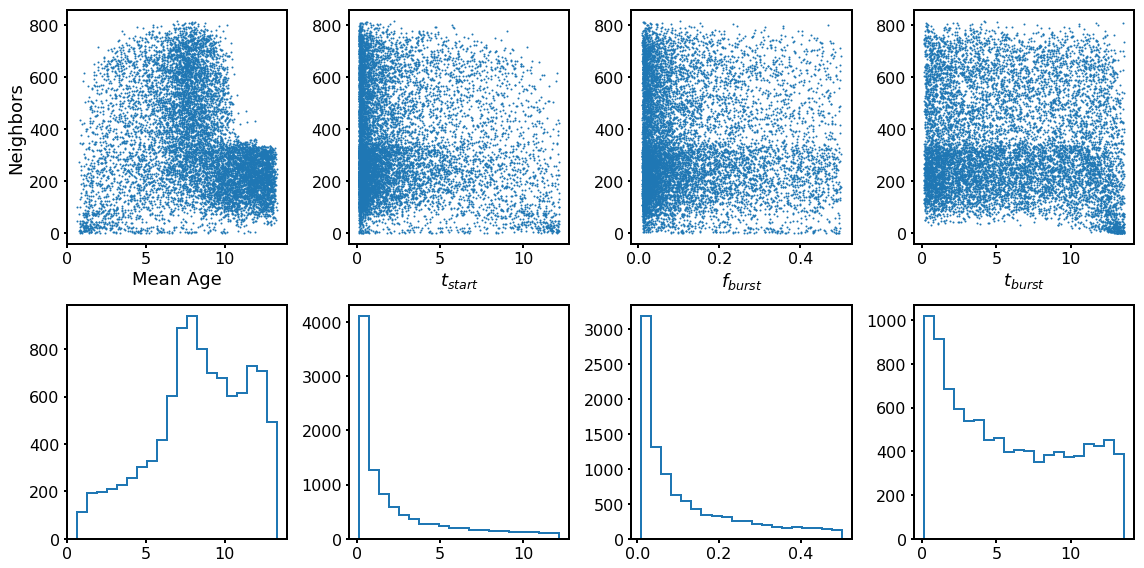

In [101]:
# do a dense distance matrix for a 10,000 spectrum subset of the data to determine dimensionality, radius

#distmatrix = euclidean_distances(spectra[:10000,:])

# ns_all = []
# rs = np.logspace(-1.5,1.5,300)

# for r in rs:
#     test = distmatrix <= r
#     neighbors = np.sum(test, axis=0) 
#     ns_all.append(np.mean(neighbors) - 1.)  # account for one 0 per row (distance to self)
    
r = 10 ** 0.17
test = distmatrix <= r
neighbors = np.sum(test, axis=0)

fig, ax = plt.subplots(2, 4, figsize=(16,8))
ax = ax.ravel()
ax[0].scatter(mean_ages[:10000], neighbors, s=1)
ax[0].set_ylabel('Neighbors')
ax[0].set_xlabel('Mean Age')
ax[1].scatter(sf_begins[:10000], neighbors, s=1)
ax[1].set_xlabel('$t_{start}$')
ax[2].scatter(fbursts[:10000], neighbors, s=1)
ax[2].set_xlabel('$f_{burst}$')
ax[3].scatter(tbursts[:10000], neighbors, s=1)
ax[3].set_xlabel('$t_{burst}$')
ax[4].hist(mean_ages[:10000], bins=20, histtype='step', linewidth=2);
ax[5].hist(sf_begins[:10000], bins=20, histtype='step', linewidth=2);
ax[6].hist(fbursts[:10000], bins=20, histtype='step', linewidth=2);
ax[7].hist(tbursts[:10000], bins=20, histtype='step', linewidth=2);
plt.tight_layout()

23
Distance between the young disconnected and mean spectra is 20.7091576225
Distance between the young connected and mean spectra is 14.5043651094
Distance between the young-ish disconnected and mean spectra is 14.3391535357


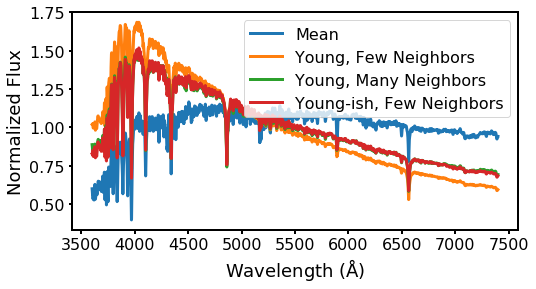

In [111]:
younginds = np.where((mean_ages[:10000] < 1.0) * (neighbors < 100))[0]
youngconninds = np.where((mean_ages[:10000] < 1.0) * (neighbors > 100))[0]
youngishinds = np.where((mean_ages[:10000] < 5.0) * (neighbors < 100))[0]

print np.sum((mean_ages[:10000] < 1.0) * (neighbors < 100))

meanall = np.mean(spectra, axis=0)
meanyoung = np.mean(spectra[younginds], axis=0)
meanyoungconn = np.mean(spectra[youngconninds], axis=0)
meanyoungish = np.mean(spectra[youngishinds], axis=0)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(wave, meanall, label='Mean')
ax.plot(wave, meanyoung, label='Young, Few Neighbors')
ax.plot(wave, meanyoungconn, label='Young, Many Neighbors')
ax.plot(wave, meanyoungish, label='Young-ish, Few Neighbors')
ax.plot()
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)')
ax.set_ylabel('Normalized Flux')
plt.legend()

dist1 = np.sum((meanall-meanyoung)**2) ** 0.5
dist2 = np.sum((meanall-meanyoungconn)**2) ** 0.5
dist3 = np.sum((meanall-meanyoungish)**2) ** 0.5
print "Distance between the young disconnected and mean spectra is {}".format(dist1)
print "Distance between the young connected and mean spectra is {}".format(dist2)
print "Distance between the young-ish disconnected and mean spectra is {}".format(dist3)

for radius 0.03, 0 < N_neightbors < 2, mean = 0.00, log(N)=-2.42
for radius 0.07, 0 < N_neightbors < 2, mean = 0.04, log(N)=-1.43
for radius 0.15, 0 < N_neightbors < 7, mean = 0.45, log(N)=-0.35
for radius 0.32, 0 < N_neightbors < 28, mean = 4.76, log(N)=0.68
for radius 0.68, 0 < N_neightbors < 144, mean = 44.57, log(N)=1.65
for radius 1.47, 0 < N_neightbors < 812, mean = 337.30, log(N)=2.53
for radius 3.16, 2 < N_neightbors < 2252, mean = 1420.22, log(N)=3.15
for radius 6.81, 68 < N_neightbors < 4624, mean = 3521.37, log(N)=3.55
for radius 14.68, 872 < N_neightbors < 8764, mean = 6805.77, log(N)=3.83
for radius 31.62, 6431 < N_neightbors < 9999, mean = 9869.56, log(N)=3.99


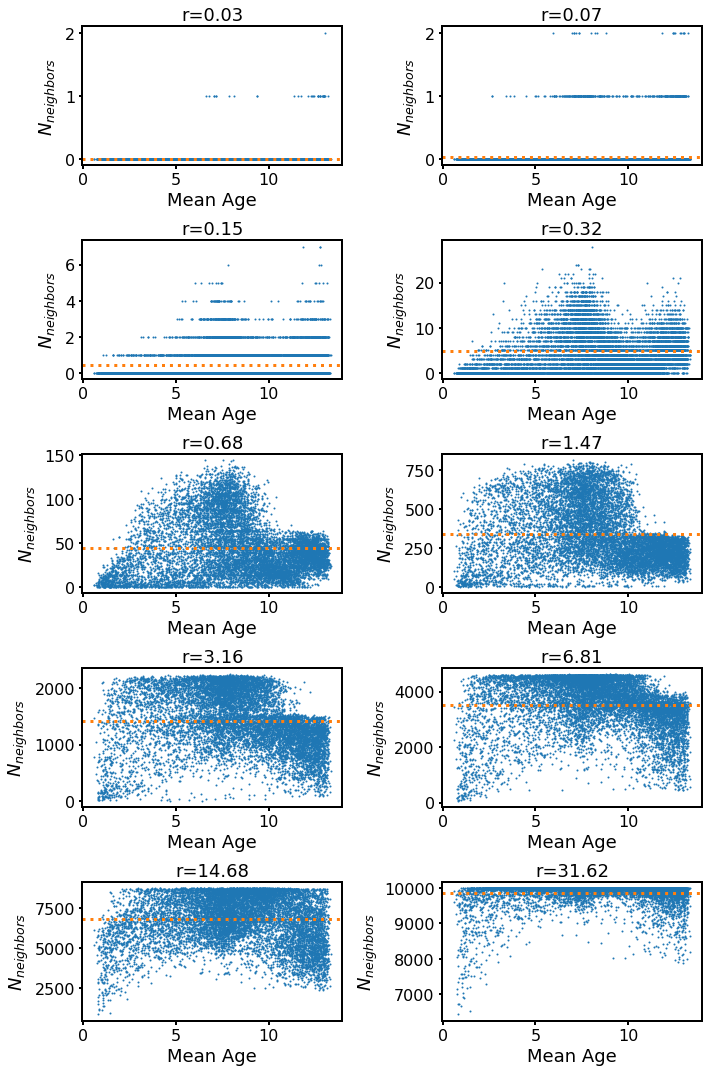

In [99]:
rs = np.logspace(-1.5,1.5,10)
fig, ax = plt.subplots(5,2, figsize=(10,15))
ax = ax.ravel()
for ii in range(len(rs)):
    test = distmatrix <= rs[ii]
    neighbors = np.sum(test, axis=0) - 1  # account for one 0 per row (distance to self)
    print 'for radius %.2f, %d < N_neightbors < %d, mean = %.2f, log(N)=%.2f' % (rs[ii], np.min(neighbors), 
                                                                    np.max(neighbors), np.mean(neighbors),
                                                                                np.log10(np.mean(neighbors)))
    ax[ii].scatter(mean_ages[:10000], neighbors, s=1);
    ax[ii].axhline(np.mean(neighbors), linestyle=':', color='C1')
    ax[ii].set_xlabel(r'Mean Age');
    ax[ii].set_ylabel(r'$N_{neighbors}$');
    ax[ii].set_title('r=%.2f' % rs[ii])
#     ax[ii].text(0.35, 0.75, 'r=%.2f\nlog(r)=%.2f' % (rs[ii], np.log10(rs[ii])), \
#                 transform=ax[ii].transAxes, fontsize=18, fontdict={'color': 'black'})
    plt.tight_layout()

for radius 0.03, 0 < N_neightbors < 2, mean = 0.00, log(N)=-2.42
for radius 0.07, 0 < N_neightbors < 2, mean = 0.04, log(N)=-1.43
for radius 0.15, 0 < N_neightbors < 7, mean = 0.45, log(N)=-0.35
for radius 0.32, 0 < N_neightbors < 28, mean = 4.76, log(N)=0.68
for radius 0.68, 0 < N_neightbors < 144, mean = 44.57, log(N)=1.65
for radius 1.47, 0 < N_neightbors < 812, mean = 337.30, log(N)=2.53
for radius 3.16, 2 < N_neightbors < 2252, mean = 1420.22, log(N)=3.15
for radius 6.81, 68 < N_neightbors < 4624, mean = 3521.37, log(N)=3.55
for radius 14.68, 872 < N_neightbors < 8764, mean = 6805.77, log(N)=3.83
for radius 31.62, 6431 < N_neightbors < 9999, mean = 9869.56, log(N)=3.99


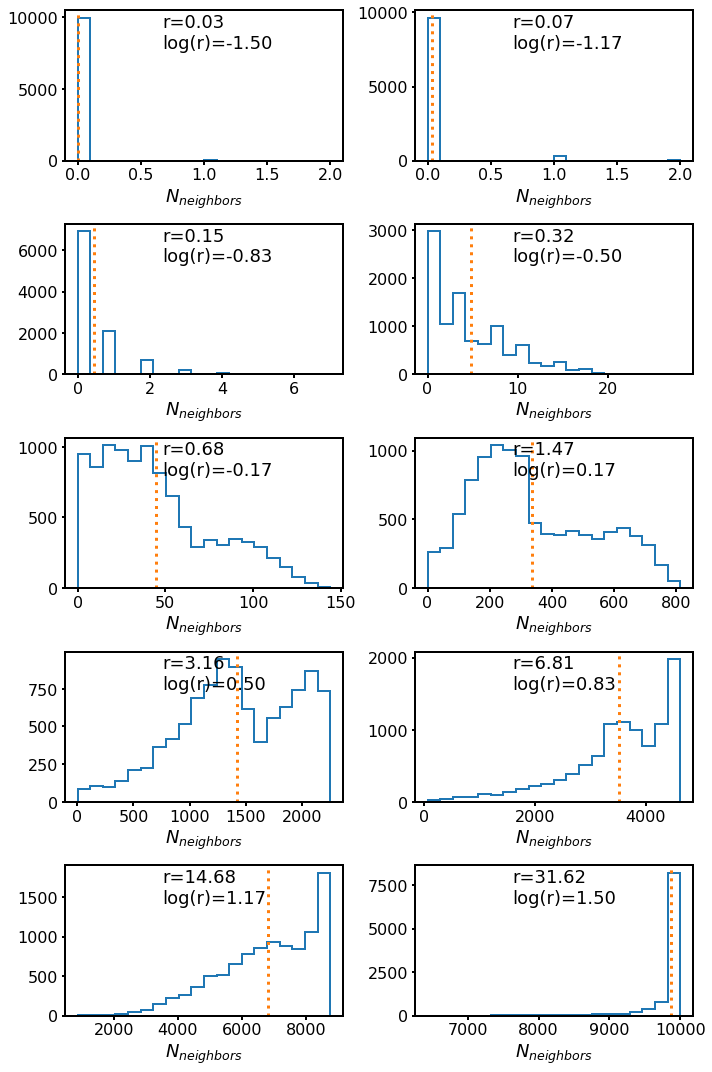

In [8]:
rs = np.logspace(-1.5,1.5,10)
ns = []
stdevs = []
min_ns = []
max_ns = []
fig, ax = plt.subplots(5,2, figsize=(10,15))
ax = ax.ravel()
for ii in range(len(rs)):
    test = distmatrix <= rs[ii]
    neighbors = np.sum(test, axis=0) - 1  # account for one 0 per row (distance to self)
    print 'for radius %.2f, %d < N_neightbors < %d, mean = %.2f, log(N)=%.2f' % (rs[ii], np.min(neighbors), 
                                                                    np.max(neighbors), np.mean(neighbors),
                                                                                np.log10(np.mean(neighbors)))
    stdevs.append(np.std(neighbors))
    ns.append(np.mean(neighbors))
    min_ns.append(np.min(neighbors))
    max_ns.append(np.max(neighbors))
    n, bins, patches = ax[ii].hist(neighbors, bins=20, histtype='step', linewidth=2)
    ax[ii].axvline(np.mean(neighbors), linestyle=':', color='C1')
    ax[ii].set_xlabel(r'$N_{neighbors}$');
    ax[ii].text(0.35, 0.75, 'r=%.2f\nlog(r)=%.2f' % (rs[ii], np.log10(rs[ii])), \
                transform=ax[ii].transAxes, fontsize=18, fontdict={'color': 'black'})
    plt.tight_layout()

In [9]:
logr = np.log10(rs)
logn = np.log10(ns)
logmin = np.log10(min_ns)
logmax = np.log10(max_ns)
whfit = logr < 0.1

# fit a quick line to linear part -- get dimension of data
from scipy.optimize import curve_fit

def f(x, A, B):
    return A*x + B

A, B = curve_fit(f, logr[whfit], logn[whfit])[0]
print "The dimension of the data is", A

The dimension of the data is 3.07517736207


/Users/Grace/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


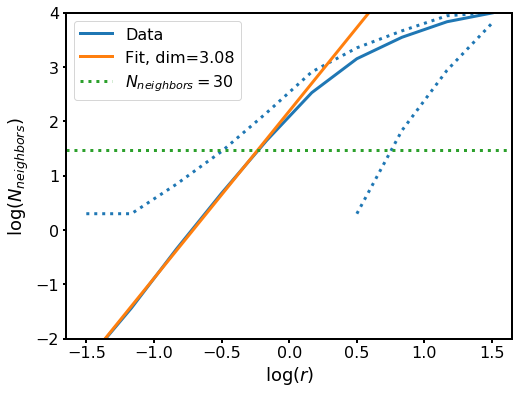

In [10]:
plt.figure(figsize=(8,6));
plt.plot(logr, logn, label='Data');
plt.plot(logr, logmin, ':', c='C0')
plt.plot(logr, logmax, ':', c='C0')
plt.xlabel(r'$\log(r)$');
plt.ylabel(r'$\log(N_{neighbors})$');
plt.plot(logr, f(logr, A, B), label='Fit, dim=%.2f' % A);
# plt.axvline(0.1, linestyle=':', color='k') # threshold below which linear fit was performed, log(r) = 0.1
plt.axhline(np.log10(30), linestyle=':', color='C2', label=r'$N_{neighbors}=30$')  # where N_neighbors = 30
plt.ylim(-2,4);
plt.legend()

In [19]:
targetN = 30
idx = (np.abs(logn - np.log10(targetN))).argmin()
print 'N=%d neighbors at log(r)=%.2f. 2x this radius gives log(r)=%.2f.' % (targetN, logr[idx], 
                                                                            np.log10(10**logr[idx] * 2))

N=30 neighbors at log(r)=-0.17. 2x this radius gives log(r)=0.13.


## Now, split sample into quartiles of mean stellar age and do the distance matrix calculation for different chunks - does the optimal radius change?

In [41]:
age_q1 = np.where(mean_ages < np.percentile(mean_ages, 25))
age_q2 = np.where((mean_ages > np.percentile(mean_ages, 25)) * (mean_ages <= np.percentile(mean_ages, 50)))
age_q3 = np.where((mean_ages > np.percentile(mean_ages, 50)) * (mean_ages <= np.percentile(mean_ages, 75)))
age_q4 = np.where(mean_ages >= np.percentile(mean_ages, 75))
print np.min(mean_ages), np.max(mean_ages)
print np.min(mean_ages[age_q1]), np.max(mean_ages[age_q1])
print np.min(mean_ages[age_q2]), np.max(mean_ages[age_q2])
print np.min(mean_ages[age_q3]), np.max(mean_ages[age_q3])
print np.min(mean_ages[age_q4]), np.max(mean_ages[age_q4])

0.556538728751 13.3756404563
0.556538728751 6.59881437313
6.59890385102 8.49269751483
8.49273505121 10.8281594796
10.8281670178 13.3756404563


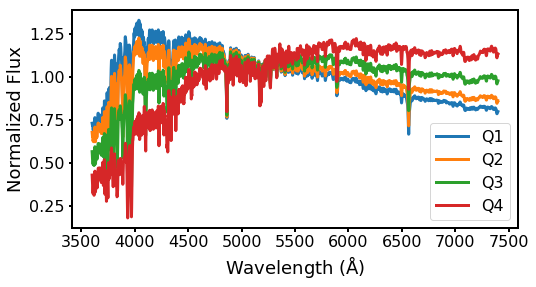

In [49]:
fig, ax = plt.subplots(figsize=(8,4))
quartile = 1
for inds in [age_q1, age_q2, age_q3, age_q4]:
    ax.plot(wave, np.mean(spectra[inds[0]], axis=0), label='Q{}'.format(quartile))
    quartile += 1
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)')
ax.set_ylabel('Normalized Flux')
plt.legend()

In [50]:
np.shape(spectra[age_q1[0],:][:10000,:])

(10000, 4220)

In [59]:
# now, do the distance matrix calculation and radius estimation for 10,000 spectra from each age quartile

rs = np.logspace(-1.5,1.5,300)
ns = np.zeros((4, len(rs)))

quartiles = [age_q1, age_q2, age_q3, age_q4]

for ii in range(4):
    inds = quartiles[ii][0]
    distmatrix = euclidean_distances(spectra[inds,:][:10000,:])
    ns_temp = []
    for r in rs:
        test = distmatrix <= r
        neighbors = np.sum(test, axis=0) 
        ns_temp.append(np.mean(neighbors) - 1.)
    ns[ii,:] = ns_temp

Quartile 1: dimension =3.48453356911, optimal radius=1.03532527977
Quartile 2: dimension =2.94465571168, optimal radius=0.74921866971
Quartile 3: dimension =3.16603067785, optimal radius=1.10962735052
Quartile 4: dimension =2.679803534, optimal radius=0.802987760153


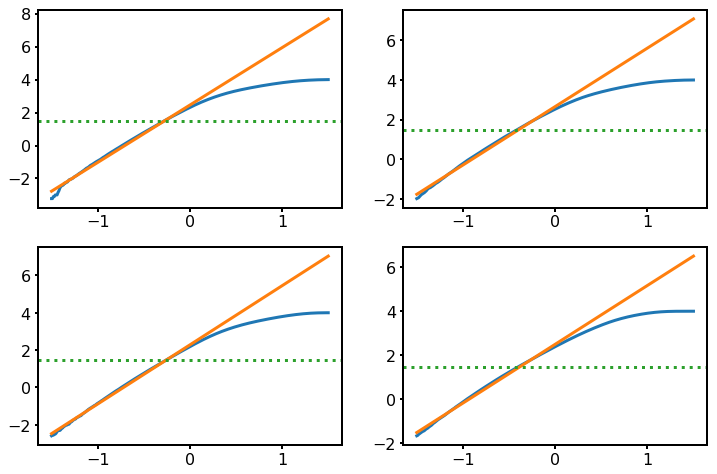

In [95]:
# visualize and fit a line to each subset
from scipy.optimize import curve_fit
def f(x, A, B):
    return A*x + B

logr = np.log10(rs)
logn = np.log10(ns)
whfit = logr < 0.1
targetN = 30

fig, ax = plt.subplots(2, 2, figsize=(12,8))
ax = ax.ravel()

for ii in range(4):
    idx = (np.abs(logn[ii,:] - np.log10(targetN))).argmin()
    ropt = 10**logr[idx] * 2
    A, B = curve_fit(f, logr[whfit], logn[ii,:][whfit])[0]
    print "Quartile {}: dimension ={}, optimal radius={}".format(ii+1, A, ropt)
    ax[ii].plot(logr, logn[ii,:])
    ax[ii].plot(logr, f(logr, A, B))
    ax[ii].axhline(np.log10(30), linestyle=':', color='C2')

## Reproduce embedding with "optimal" radius from initial attempt (using 10,000 spectra for speed and so that it is represented by the number of neighbors in the plot above), then try using a different radius for the similarity calculation

In [20]:
radius = 10**0.13
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra[:10000,:])
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

# update radius -- unclear why... 
new_radius = np.max(adjacency_matrix.data)
print new_radius

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

ndim=10
spectral = SpectralEmbedding(n_components=ndim, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'
wh = labels == 0
use_embed = embed[wh,:] * 1000

1.34895
12 components
9984 spectra in first component


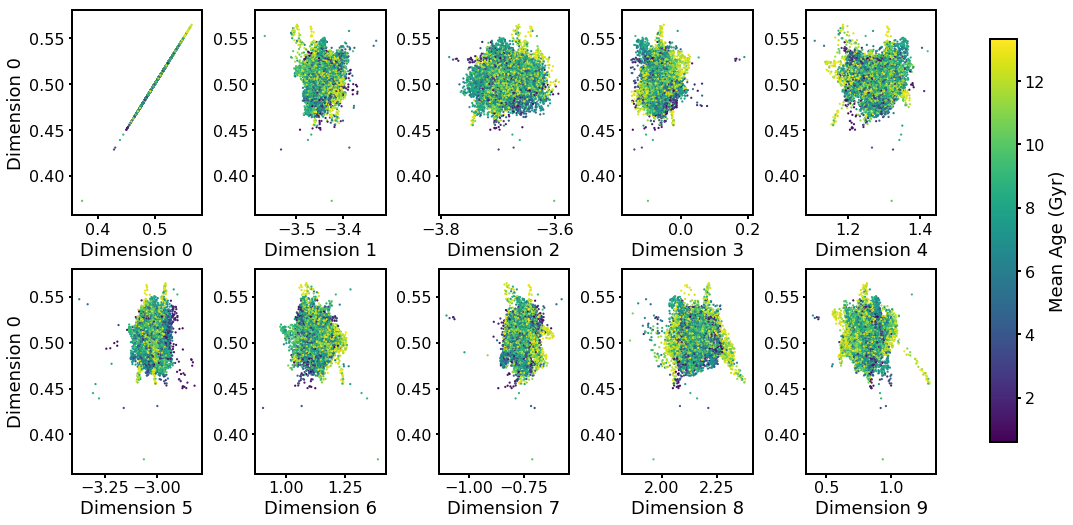

In [21]:
plot_vsdim_cc(ndim, use_embed[:,0], mean_ages[:10000][wh], ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed)

### Now try using a radius for the Laplacian that is 1/5 of the maximum radius in the adjacency matrix

In [112]:
radius = 10**0.13
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius*5, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius*5}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra[:10000,:])
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

# update radius -- unclear why... 
# new_radius = np.max(adjacency_matrix.data)
# print 'Neighborhood radius={}, Laplacian radius={}'.format(radius, new_radius/5.)

affinity_kwds = {'radius':radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

ndim=10
spectral = SpectralEmbedding(n_components=ndim, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'
wh = labels == 0
use_embed = embed[wh,:] * 1000

1 components
10000 spectra in first component


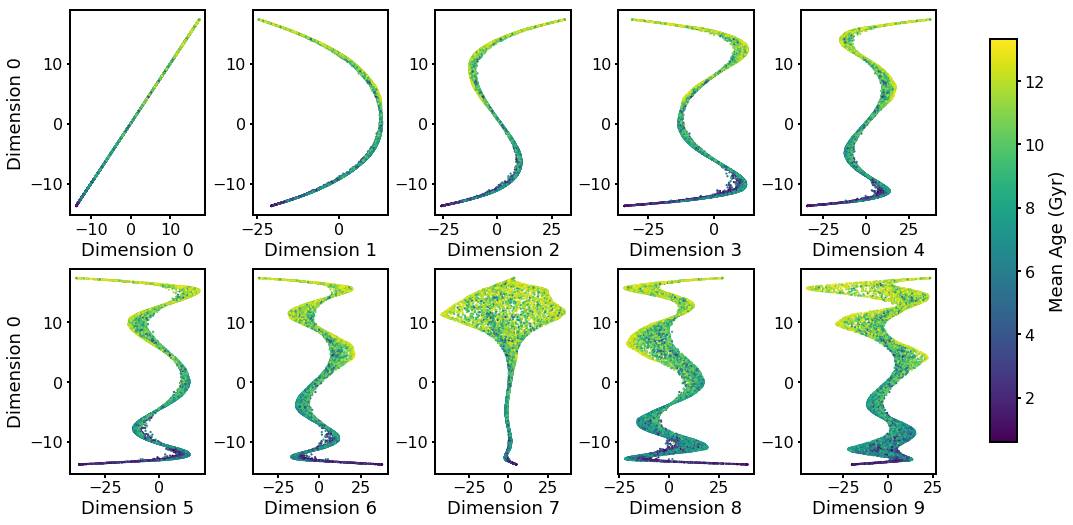

In [113]:
plot_vsdim_cc(ndim, use_embed[:,0], mean_ages[:10000][wh], ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed)

## This did not change things. Huh. Let's try using different radii where we start with log(r)=0.5

In [32]:
radius = 10**0.5
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra[:10000,:])
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

# update radius -- unclear why... 
new_radius = np.max(adjacency_matrix.data)
print new_radius

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

ndim=10
spectral = SpectralEmbedding(n_components=ndim, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'
wh = labels == 0
use_embed = embed[wh,:] * 1000

3.16223
1 components
10000 spectra in first component


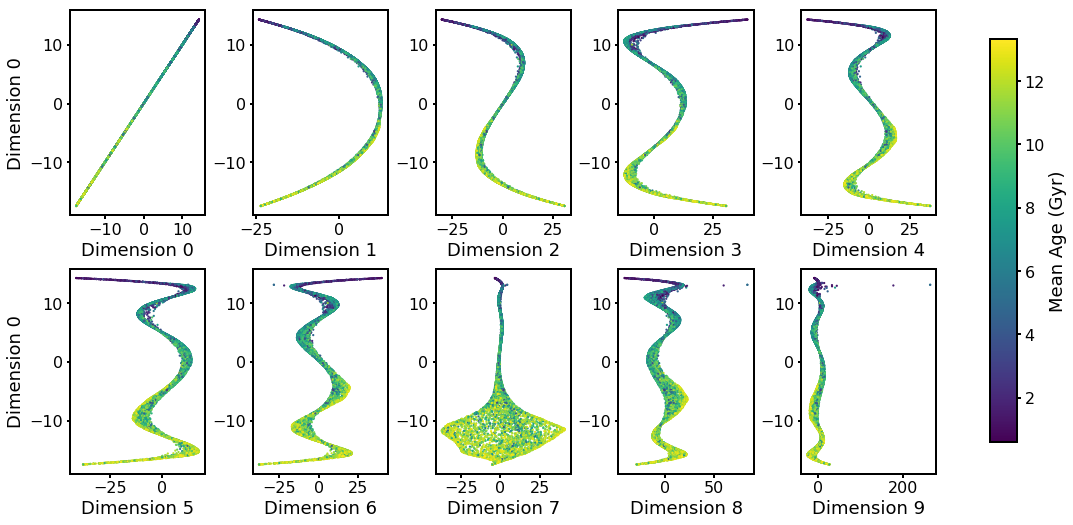

In [33]:
plot_vsdim_cc(ndim, use_embed[:,0], mean_ages[:10000][wh], ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed)

### Now try using a radius for the Laplacian that is 1/5 of the maximum radius in the adjacency matrix

In [61]:
radius = 10**0.5
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra[:10000,:])
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

# update radius -- unclear why... 
new_radius = np.max(adjacency_matrix.data)
print 'Neighborhood radius={}, Laplacian radius={}'.format(radius, new_radius/5.)

affinity_kwds = {'radius':new_radius/5.}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius/5.}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

ndim=10
spectral = SpectralEmbedding(n_components=ndim, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'
wh = labels == 0
use_embed = embed[wh,:] * 1000

Neighborhood radius=3.16227766017, Laplacian radius=0.632445383072
1 components
10000 spectra in first component


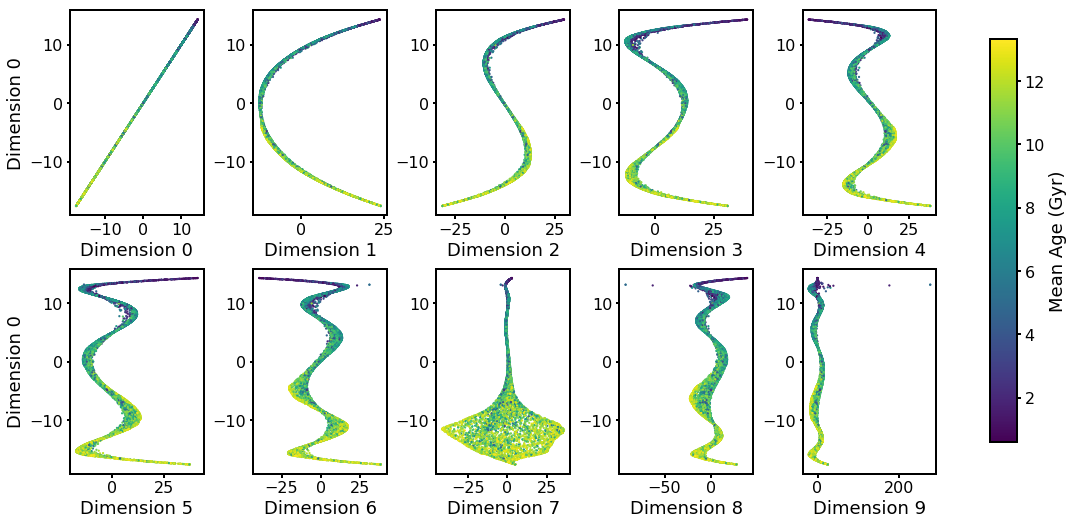

In [62]:
plot_vsdim_cc(ndim, use_embed[:,0], mean_ages[:10000][wh], ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed)

# Now try embeddings for old spectra only, then young

In [66]:
radius = 10**0.5 #-0.09 -- "optimal" radius gave similar junk to "optimal" for full dataset
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

inds = age_q4[0]
geom.set_data_matrix(spectra[inds,:][:10000,:])
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

# update radius -- unclear why... 
new_radius = np.max(adjacency_matrix.data)
print 'Neighborhood radius={}, Laplacian radius={}'.format(radius, new_radius/5.)

affinity_kwds = {'radius':new_radius/5.}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius/5.}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

ndim=10
spectral = SpectralEmbedding(n_components=ndim, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'
wh = labels == 0
use_embed = embed[wh,:] * 1000

Neighborhood radius=3.16227766017, Laplacian radius=0.632225227356
1 components
10000 spectra in first component


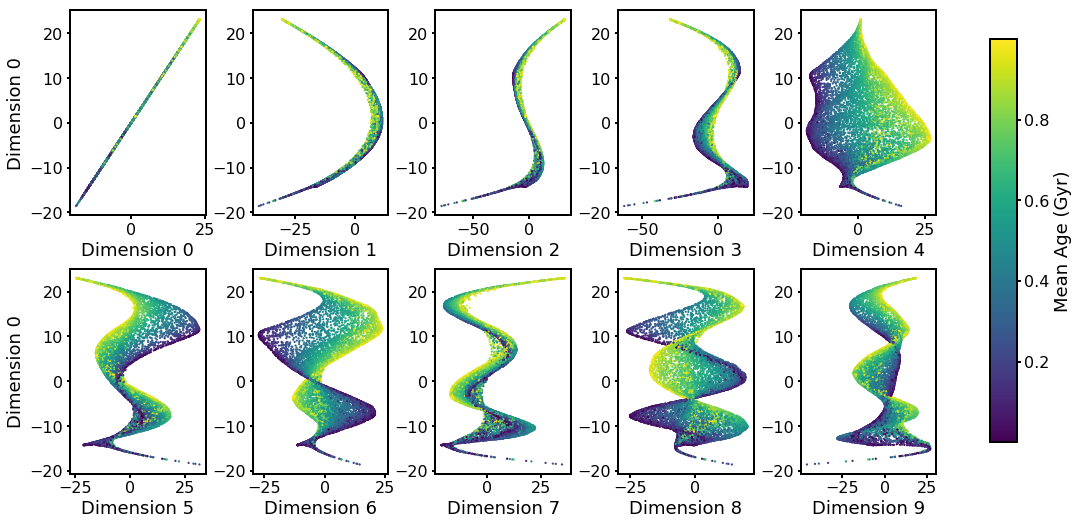

In [70]:
plot_vsdim_cc(ndim, use_embed[:,0], dusts[inds][:10000][wh], ylabel='Dimension 0', cblabel='Dust'

In [114]:
radius = 10**0.5 #-0.09 -- "optimal" radius gave similar junk to "optimal" for full dataset
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

inds = age_q1[0]
geom.set_data_matrix(spectra[inds,:][:10000,:])
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

# update radius -- unclear why... 
new_radius = np.max(adjacency_matrix.data)
print 'Neighborhood radius={}, Laplacian radius={}'.format(radius, new_radius/5.)

affinity_kwds = {'radius':new_radius/5.}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius/5.}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

ndim=10
spectral = SpectralEmbedding(n_components=ndim, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'
wh = labels == 0
use_embed = embed[wh,:] * 1000

Neighborhood radius=3.16227766017, Laplacian radius=0.6323366642
1 components
10000 spectra in first component


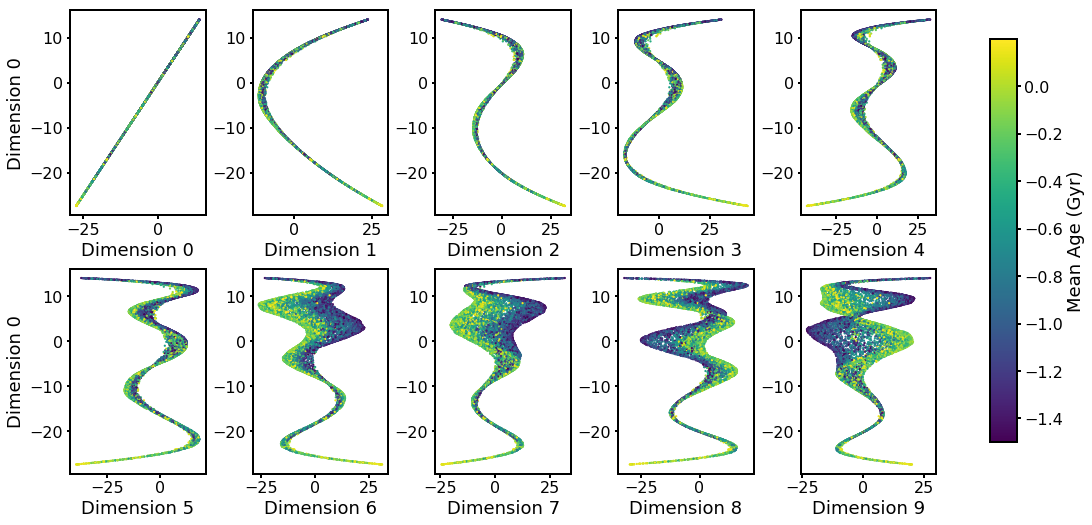

In [134]:
plot_vsdim_cc(ndim, use_embed[:,0], zs[inds][:10000][wh], ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed)

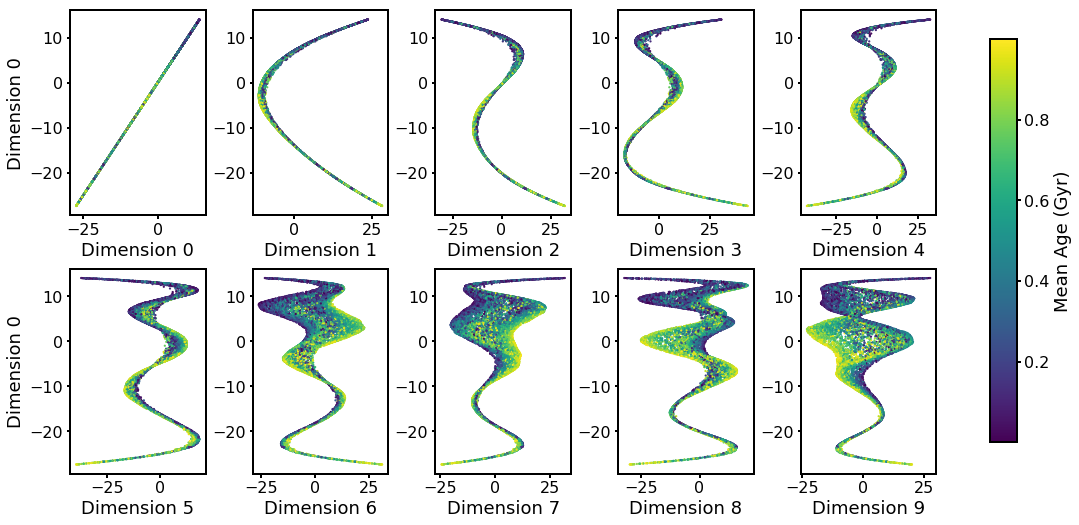

In [135]:
plot_vsdim_cc(ndim, use_embed[:,0], dusts[inds][:10000][wh], ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed)

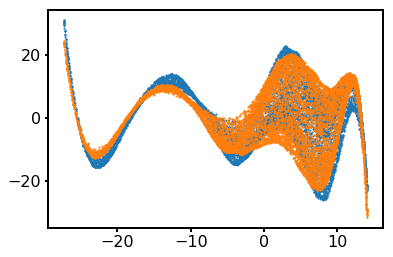

In [141]:
plt.figure()
plt.scatter(use_embed[:,0], use_embed[:,6], s=1)
plt.scatter(use_embed[:,0], -use_embed[:,7], s=1)

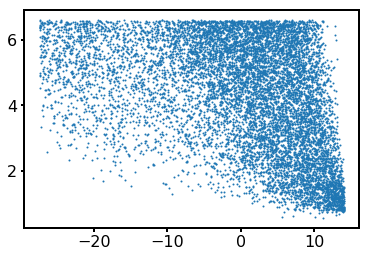

In [143]:
plt.figure()
plt.scatter(use_embed[:,0], mean_ages[inds][:10000], s=1)

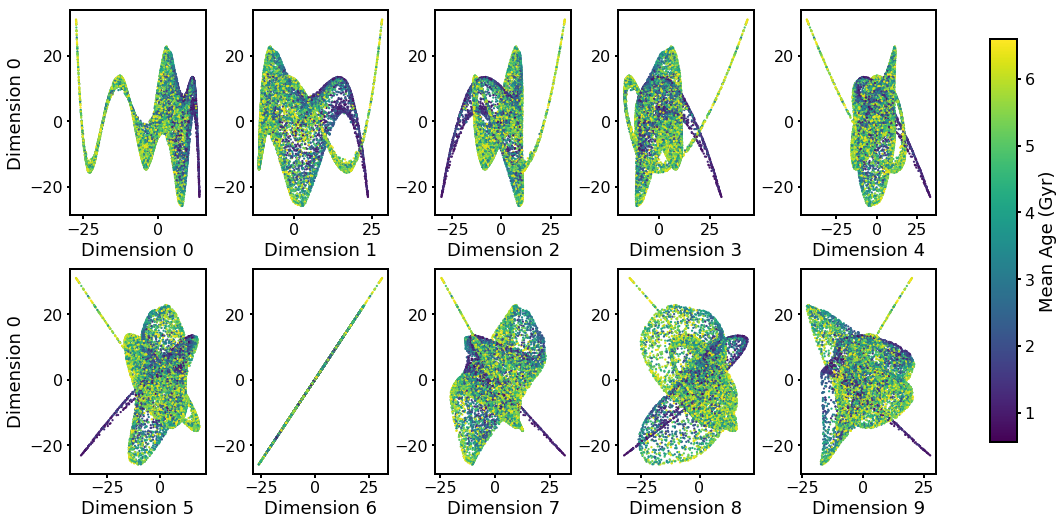

In [116]:
plot_vsdim_cc(ndim, use_embed[:,6], mean_ages[inds][:10000][wh], ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed)

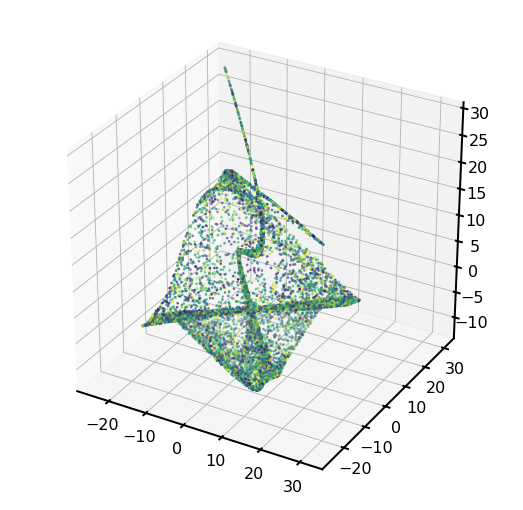

In [140]:
# plt.figure(figsize=(9,9))
# plt.scatter(use_embed[:,7], use_embed[:,6], c=mean_ages[:10000], s=3)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(use_embed[:,7], use_embed[:,6], zs=use_embed[:,1], c=zs[:10000], s=3)

## Now try running the estimate_radius code in megaman

In [74]:
# this is for the young spectra in the previous embedding attempt

from megaman.utils import estimate_radius as er
test = er.run_estimate_radius(spectra[inds,:][:10000,:], adjacency_matrix, np.arange(500).tolist(), 4, 0.1, 10.0, 20, 
                              False, search_space='logspace')

ImportError: cannot import name estimate_radius